In [1]:
import numpy as np
from scipy.constants import pi
import time
import matplotlib.pyplot as plt
import finufft

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [129]:
def maxDiff(a1, a2):
    diff = a1 - a2
    return np.amax(np.abs(diff))

## Type 1 (nonuiform to uniform)

$$f_k = \sum_{j=1}^{M} c_j e^{\pm ik*x_j}$$

for $k \in K$.

$M$ - number of nonuniform points

$x$ - nonuniform points

$c$ - source strengths

$N$ of $N1$ - number of uniform points requested

In [3]:
def matvec_nufft1d1(x, c, N):
    N = N[0]
    if(N % 2 == 0):
        K = np.arange(-N/2, N/2, 1)
    else:
        K = np.arange(-(N - 1)/2, (N - 1)/2 + 1, 1)
    A = np.exp(1j * np.matmul(K.reshape(N, 1), x.reshape(1, len(x))))
    return np.matmul(A, c)

### Single Case

Working: True
matvec time: 0.003 s
nufft time: 0.003 s


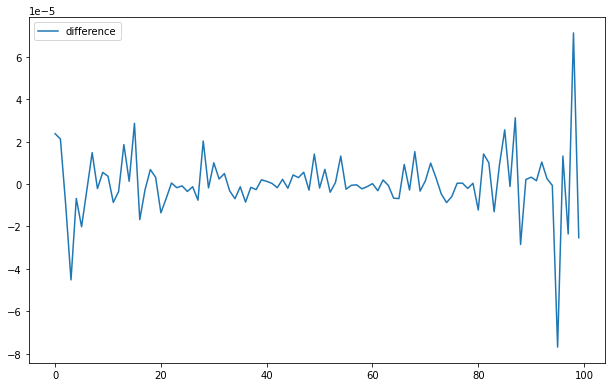

In [123]:
M = 300
x = 2 * np.pi * np.random.uniform(size=M)
c = (np.random.standard_normal(size=M)
     + 1J * np.random.standard_normal(size=M))
# c = np.sin(pi*x)
N1 = 100

t1 = time.time()
mvf = matvec_nufft1d1(x, c, (N1, ))
t2 = time.time()
f = finufft.nufft1d1(x, c, (N1, ))
t3 = time.time()

print('Working:', np.allclose(mvf, f, atol=1e-6))
print('matvec time: {:.3f} s'.format((t2 - t1)))
print('nufft time: {:.3f} s'.format((t3 - t2)))

fig = plt.figure(figsize=(10,6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(np.abs(mvf)-np.abs(f), label='difference')
axes.legend()

### Vary M (number of nonuniform source points)

Text(0, 0.5, 'time (seconds)')

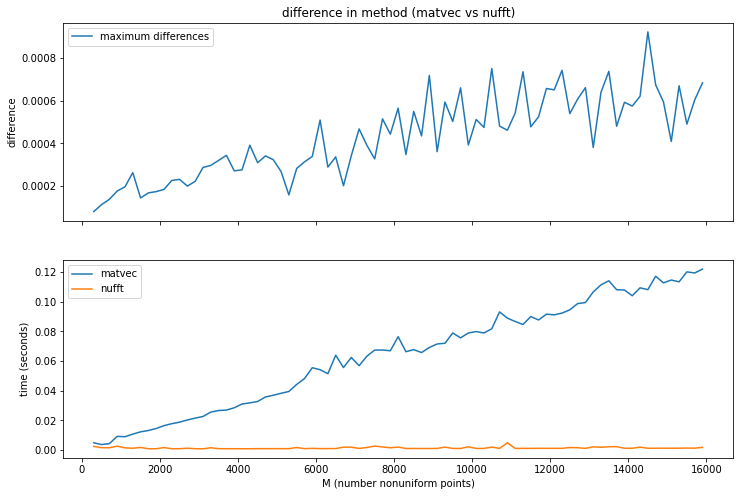

In [149]:
Mvals = np.arange(300, 16000, 200)
maxDiffs = np.zeros(len(Mvals))
matvecTime = np.zeros(len(Mvals))
nufftTime = np.zeros(len(Mvals))
for i in range(len(Mvals)):
    M = Mvals[i]
    x = 2 * np.pi * np.random.uniform(size=M)
    c = (np.random.standard_normal(size=M)
         + 1J * np.random.standard_normal(size=M))
    # c = np.sin(pi*x)
    N1 = 16000

    t1 = time.time()
    mvf = matvec_nufft1d1(x, c, (N1, ))
    t2 = time.time()
    f = finufft.nufft1d1(x, c, (N1, ))
    t3 = time.time()
    
    maxDiffs[i] = maxDiff(mvf, f)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Mvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Mvals, matvecTime, label='matvec')
ax2.plot(Mvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('M (number source points)')
ax2.set_ylabel('time (seconds)')

### Vary N (number of uniform target points)

Text(0, 0.5, 'time (seconds)')

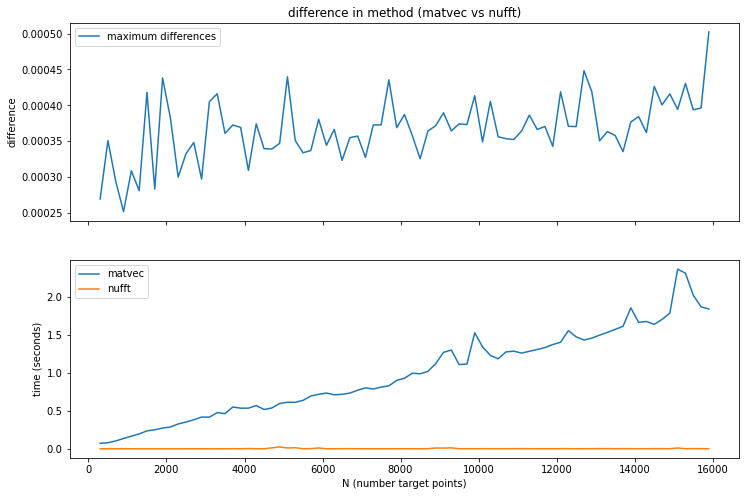

In [153]:
Nvals = np.arange(300, 16000, 200)
maxDiffs = np.zeros(len(Nvals))
matvecTime = np.zeros(len(Nvals))
nufftTime = np.zeros(len(Nvals))
for i in range(len(Nvals)):
    M = 2000
    x = 2 * np.pi * np.random.uniform(size=M)
    c = (np.random.standard_normal(size=M)
         + 1J * np.random.standard_normal(size=M))
    # c = np.sin(pi*x)
    N1 = Nvals[i]

    t1 = time.time()
    mvf = matvec_nufft1d1(x, c, (N1, ))
    t2 = time.time()
    f = finufft.nufft1d1(x, c, (N1, ))
    t3 = time.time()
    
    maxDiffs[i] = maxDiff(mvf, f)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Nvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Nvals, matvecTime, label='matvec')
ax2.plot(Nvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('N (number target points)')
ax2.set_ylabel('time (seconds)')

## Type 2 (uniform to nonuniform)

$$c_j = \sum_{k \in K} f_k e^{\pm ik*x_j}$$

for $j = 1, ..., M$.

$M$ - number of nonuniform points

$f$ - "Fourier mode coefficients" (Uniform input)

$x$ - nonuniform points

$N$ or $N1$ - number of uniform points

In [172]:
def matvec_nufft1d2(x, f):
    N = len(f)
    M = len(x)
    if(N % 2 == 0):
        K = np.arange(-N/2, N/2, 1)
    else:
        K = np.arange(-(N - 1)/2, (N - 1)/2 + 1, 1)
    A = np.exp(-1j * np.matmul(x.reshape(M, 1), K.reshape(1, N)))
    return np.matmul(A, f)

### Single case

Working: False
matvec time: 0.002 s
nufft time: 0.002 s


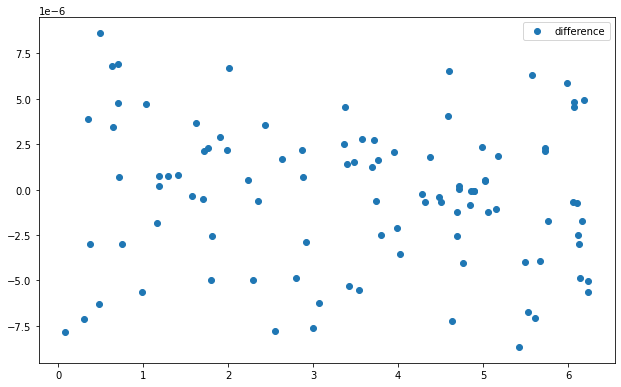

In [176]:
M = 100
x = 2 * np.pi * np.random.uniform(size=M)
N1 = 50
f = (np.random.standard_normal(size=(N1, ))
     + 1J * np.random.standard_normal(size=(N1, )))

t1 = time.time()
mvc = matvec_nufft1d2(x, f)
t2 = time.time()
c = finufft.nufft1d2(x, f)
t3 = time.time()

print('Working:', np.allclose(mvc, c))
print('matvec time: {:.3f} s'.format((t2 - t1)))
print('nufft time: {:.3f} s'.format((t3 - t2)))

fig = plt.figure(figsize=(10,6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x, np.abs(mvc)-np.abs(c), 'o', label='difference')
axes.legend()

### Vary M

Text(0, 0.5, 'time (seconds)')

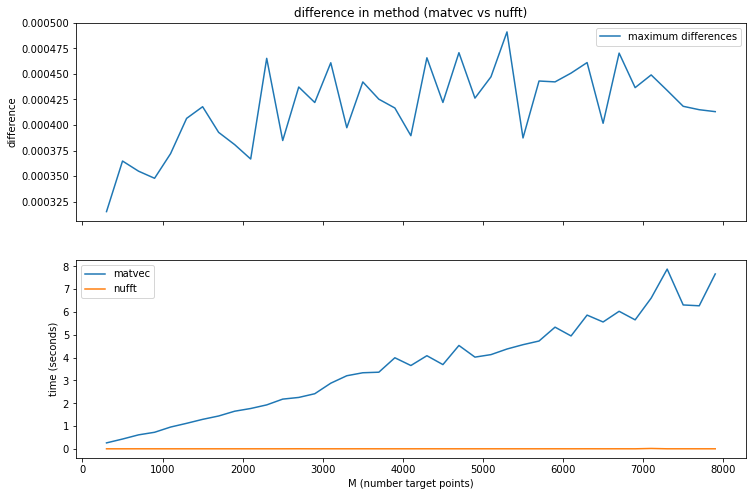

In [177]:
Mvals = np.arange(300, 8000, 200)
maxDiffs = np.zeros(len(Mvals))
matvecTime = np.zeros(len(Mvals))
nufftTime = np.zeros(len(Mvals))
for i in range(len(Mvals)):
    M = Mvals[i]
    x = 2 * np.pi * np.random.uniform(size=M)
    N1 = 16000
    f = (np.random.standard_normal(size=(N1, ))
         + 1J * np.random.standard_normal(size=(N1, )))

    t1 = time.time()
    mvc = matvec_nufft1d2(x, f)
    t2 = time.time()
    c = finufft.nufft1d2(x, f)
    t3 = time.time()
    
    maxDiffs[i] = maxDiff(mvc, c)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Mvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Mvals, matvecTime, label='matvec')
ax2.plot(Mvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('M (number target points)')
ax2.set_ylabel('time (seconds)')

### Vary N

Text(0, 0.5, 'time (seconds)')

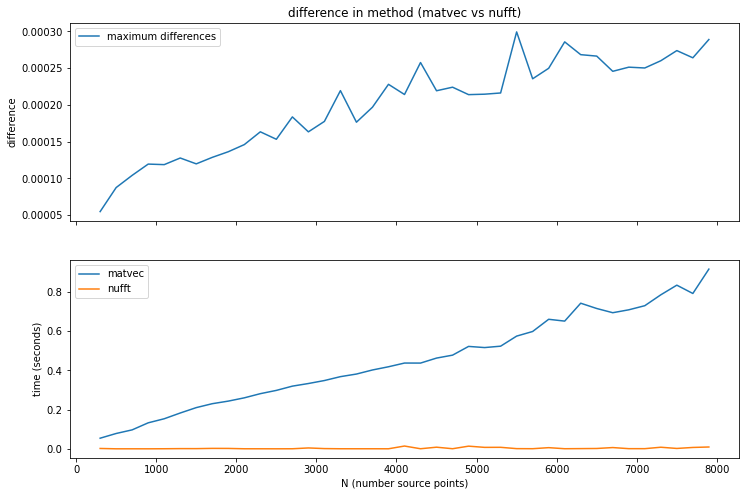

In [178]:
Nvals = np.arange(300, 8000, 200)
maxDiffs = np.zeros(len(Nvals))
matvecTime = np.zeros(len(Nvals))
nufftTime = np.zeros(len(Nvals))
for i in range(len(Nvals)):
    M = 2000
    x = 2 * np.pi * np.random.uniform(size=M)
    N1 = Nvals[i]
    f = (np.random.standard_normal(size=(N1, ))
         + 1J * np.random.standard_normal(size=(N1, )))

    t1 = time.time()
    mvc = matvec_nufft1d2(x, f)
    t2 = time.time()
    c = finufft.nufft1d2(x, f)
    t3 = time.time()
    
    maxDiffs[i] = maxDiff(mvc, c)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Nvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Nvals, matvecTime, label='matvec')
ax2.plot(Nvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('N (number source points)')
ax2.set_ylabel('time (seconds)')

## Type 3 (nonuniform to nonuniform)

$$f_k = \sum_{j=1}^{M} c_j e^{\pm is_k * x_j}$$

for $k = 1, ..., N$.

$M$ - number of nonuniform source points

$x$ - nonuniform source points

$c$ - source strengths

$N$ - number of nonuniform target points

$s$ - nonuniform target points

In [30]:
def matvec_nufft1d3(x, c, s):
    N = len(s)
    M = len(x)
    if(N % 2 == 0):
        K = np.arange(-N/2, N/2, 1)
    else:
        K = np.arange(-(N - 1)/2, (N - 1)/2 + 1, 1)
    A = np.exp(1j * np.matmul(s.reshape(N, 1), x.reshape(1, M)))
    return np.matmul(A, c)

### Single case

Working: True
matvec time: 0.002 s
nufft time: 0.006 s


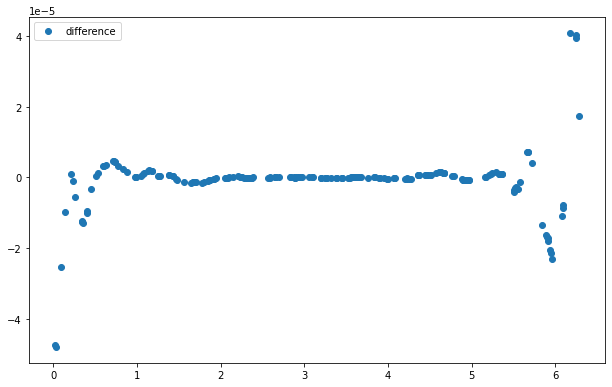

In [81]:
M = 100
N = 200
x = 2 * np.pi * np.random.uniform(size=M)
s = 2 * np.pi * np.random.uniform(size=N)
c = (np.random.standard_normal(size=M)
     + 1J * np.random.standard_normal(size=M))

t1 = time.time()
mvf = matvec_nufft1d3(x, c, s)
t2 = time.time()
f = finufft.nufft1d3(x, c, s)
t3 = time.time()

print('Working:', np.allclose(mvf, f, atol=1e-4))
print('matvec time: {:.3f} s'.format((t2 - t1)))
print('nufft time: {:.3f} s'.format((t3 - t2)))

fig = plt.figure(figsize=(10,6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(s, np.abs(mvf)-np.abs(f), 'o', label='difference')
axes.legend()

### Vary M

Text(0, 0.5, 'time (seconds)')

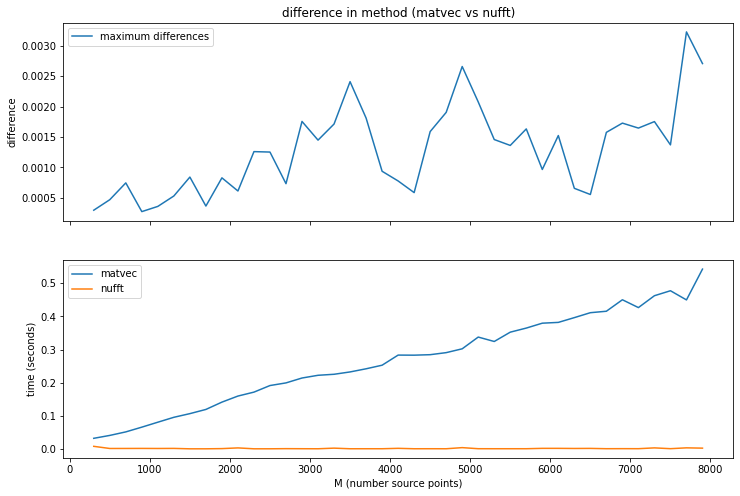

In [160]:
Mvals = np.arange(300, 8000, 200)
maxDiffs = np.zeros(len(Mvals))
matvecTime = np.zeros(len(Mvals))
nufftTime = np.zeros(len(Mvals))
for i in range(len(Mvals)):
    M = Mvals[i]
    N = 1000
    x = 2 * np.pi * np.random.uniform(size=M)
    s = 2 * np.pi * np.random.uniform(size=N)
    c = (np.random.standard_normal(size=M)
         + 1J * np.random.standard_normal(size=M))

    t1 = time.time()
    mvf = matvec_nufft1d3(x, c, s)
    t2 = time.time()
    f = finufft.nufft1d3(x, c, s)
    t3 = time.time()

    maxDiffs[i] = maxDiff(mvf, f)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Mvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Mvals, matvecTime, label='matvec')
ax2.plot(Mvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('M (number source points)')
ax2.set_ylabel('time (seconds)')

### Vary N

Text(0, 0.5, 'time (seconds)')

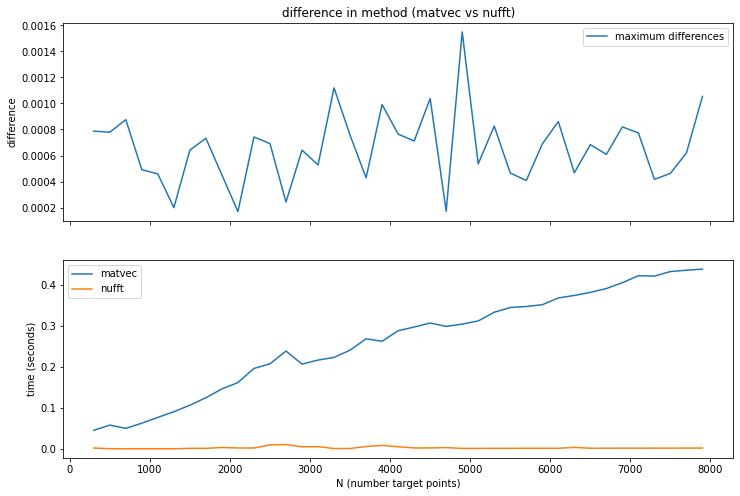

In [161]:
Nvals = np.arange(300, 8000, 200)
maxDiffs = np.zeros(len(Nvals))
matvecTime = np.zeros(len(Nvals))
nufftTime = np.zeros(len(Nvals))
for i in range(len(Nvals)):
    M = 1000
    N = Nvals[i]
    x = 2 * np.pi * np.random.uniform(size=M)
    s = 2 * np.pi * np.random.uniform(size=N)
    c = (np.random.standard_normal(size=M)
         + 1J * np.random.standard_normal(size=M))

    t1 = time.time()
    mvf = matvec_nufft1d3(x, c, s)
    t2 = time.time()
    f = finufft.nufft1d3(x, c, s)
    t3 = time.time()

    maxDiffs[i] = maxDiff(mvf, f)
    matvecTime[i] = t2 - t1
    nufftTime[i] = t3 - t2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
ax1.plot(Nvals, maxDiffs, label='maximum differences')
ax1.legend()
ax1.set_ylabel('difference')
ax1.set_title('difference in method (matvec vs nufft)')

ax2.plot(Nvals, matvecTime, label='matvec')
ax2.plot(Nvals, nufftTime, label='nufft')
ax2.legend()
ax2.set_xlabel('N (number target points)')
ax2.set_ylabel('time (seconds)')